In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [13]:
#Loading and basic obs of wine dataset

wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(codes = wine.target, categories = wine.target_names)
print(X.shape)
print(y.shape)

print('Target names:',wine.target_names)
X.head()

(178, 13)
(178,)
Target names: ['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [14]:
#Create dataframe containing both features and classes
df = X.join(pd.Series(y, name='class'))
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


# Implementing LDA from scratch 
## Linear Discriminant Analysis can be broken up into the following steps:

    1. Compute the within class and between class scatter matrices
    2. Compute the eigenvectors and corresponding eigenvalues for the scatter matrices
    3. Sort the eigenvalues and select the top k
    4. Create a new matrix containing eigenvectors that map to the k eigenvalues
    5. Obtain the new features (i.e. LDA components) by taking the dot product of the data and the matrix from step 4

In [15]:
class_feature_means = pd.DataFrame(columns = wine.target_names)
class_feature_means

,class_0,class_1,class_2


In [16]:
#For every class, we create a vector with the means of each feature.
for class_names, rows in df.groupby('class'):
    class_feature_means[class_names] = rows.mean()
# class_feature_means

In [17]:
#We calculate the within class scatter/cov matrix

within_class_scatter_matrix = np.zeros((13,13))

for class_names, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((13,13))
    
    for index,row in rows.iterrows():
        x, mc = row.values.reshape(13,1), class_feature_means[class_names].values.reshape(13,1)
        
        s+=(x-mc).dot((x-mc).T)
        
    within_class_scatter_matrix +=s

In [18]:
#We calculate the between class scatter/cov matrix 
feature_means = df.mean()

between_class_scatter_matrix = np.zeros((13,13))

for class_names in class_feature_means:
    n = len(df.loc[df['class'] == class_names].index)
    
    mc , m = class_feature_means[class_names].values.reshape(13,1), feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc -m).dot((mc-m).T)

In [19]:
#We then solve the generalized eigen balue problem
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

print(eigen_values.shape)
print(eigen_vectors.shape)

(13,)
(13, 13)


In [20]:
#We pair up the eigen vector and eigen values and sort them to get the eigen vector corresponding to the max eigen value

pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs,key=lambda z:z[0], reverse = True)

for pair in pairs:
    print(pair[0])

9.081739435042465
4.1284690456394895
9.196875146636406e-16
9.196875146636406e-16
7.826086120820187e-16
7.320905519199309e-16
7.320905519199309e-16
3.4471214726170695e-16
2.1648742254286275e-16
2.1648742254286275e-16
1.0205983866694469e-16
5.483778268522028e-17
0.0


In [21]:
#We calculate the percentage of the contribution of feature based on their eigen values

eigen_value_sums = sum(eigen_values)

print('Explained Variance')

for i,pair in enumerate(pairs):
    print('Eigenvector {} :{}'.format(i,(pair[0]/eigen_value_sums).real ))

Explained Variance
Eigenvector 0 :0.6874788878860779
Eigenvector 1 :0.3125211121139221
Eigenvector 2 :6.961945498502559e-17
Eigenvector 3 :6.961945498502559e-17
Eigenvector 4 :5.924271469496278e-17
Eigenvector 5 :5.541854642116428e-17
Eigenvector 6 :5.541854642116428e-17
Eigenvector 7 :2.6094376009720006e-17
Eigenvector 8 :1.6387888416707785e-17
Eigenvector 9 :1.6387888416707785e-17
Eigenvector 10 :7.725831035611031e-18
Eigenvector 11 :4.151167089104817e-18
Eigenvector 12 :0.0


In [22]:
#We combine the two most dominant feature dimensions 
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real
w_matrix.shape

(13, 2)

In [23]:
#We project weight matrix with our datapoints to get the redduce
x_lda = np.dot(X,w_matrix)
x_lda.shape

(178, 2)

In [24]:
#Encoding our labels
le = LabelEncoder()
y = le.fit_transform(df['class'])

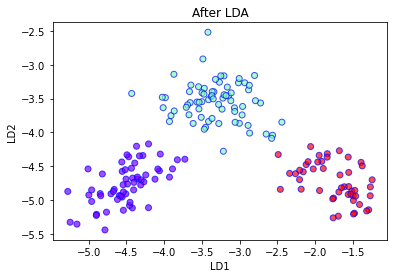

In [31]:
#Plotting our features reduced to 2 dimeansion
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title("After LDA")
plt.scatter(
    x_lda[:,0],
    x_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

# Using sklearn learn function

Explained varience ratio [0.68747889 0.31252111]


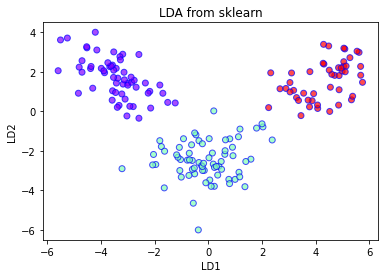

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X,y)
print('Explained varience ratio',lda.explained_variance_ratio_)

plt.title("LDA from sklearn")
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

# Using LDA as a classifier

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state=1)


lda.fit(X_train,y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        10

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

[[18  0  0]
 [ 0 17  0]
 [ 0  0 10]]


# Decision Tree
## We classify our datapoints using decision tree, once with lda and once without lda and see their accuracy

In [38]:
dt = DecisionTreeClassifier()

#Classifying with LDA
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state=1)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        10

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

[[18  0  0]
 [ 0 17  0]
 [ 0  0 10]]


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#Classifying without LDA

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       0.94      0.94      0.94        17
           2       1.00      0.90      0.95        10

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45

[[18  0  0]
 [ 1 16  0]
 [ 0  1  9]]


# Decision Tree classifier with PCA

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)


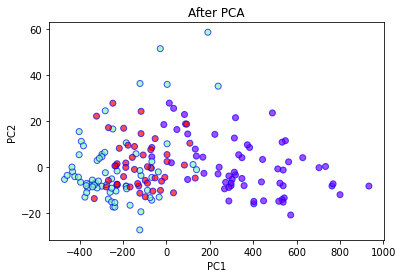

In [46]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("After PCA")
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=1)

#Classifying with PCA
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.69      0.65      0.67        17
           2       0.27      0.30      0.29        10

    accuracy                           0.64        45
   macro avg       0.60      0.59      0.60        45
weighted avg       0.65      0.64      0.65        45

[[15  0  3]
 [ 1 11  5]
 [ 2  5  3]]
